## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import math
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import datetime 

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_selected_final_24_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC  Price Prediction/data_selected_final_24_4.csv')

In [4]:
data_selected_final_24_4.columns

Index(['Date', 'Close_7sma', 'Close_3tema', 'High_30wma', 'Close_3ema',
       'Close_3BBupper', 'High_30BBmiddle', 'miners_revenue', 'tweets',
       'top100cap', 'top100cap_30roc', 'tweets_90var',
       'median_transaction_fee_3roc', 'next_day_BTC_price'],
      dtype='object')

## Functions

### Sliding Windows & splitting data

In [5]:
def sliding_intervals(df):
  
  # selecting intervals with window side of 500
  window = 500
  window_interval = []
  train_windows = []
  test_windows = []

  # splitting each window into train and test data sets
  test_window = int(window*0.2)
  train_window = int(window*0.8)
  for i in range(0, len(df), test_window):
    if len(df.iloc[i:i+train_window,:]) >=400:
      window_interval.append(df.iloc[i:i+window,:].reset_index(drop=True)) 
      train_windows.append(df.iloc[i:i+train_window,:].reset_index(drop=True))
      test_windows.append(df.iloc[i+train_window:i+window,:].reset_index(drop=True))
  return window_interval,train_windows, test_windows

### Feature Scaling

In [6]:
# function to scale data with robust and min-max scalers
def scale_data(X_fit,X_tras):
  scale1 = RobustScaler()
  scale2 = MinMaxScaler()
  scale = make_pipeline(scale1,scale2)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to scale data with standard scaler
def scale_data1(X_fit,X_tras):
  scale1 = StandardScaler()
  scale = make_pipeline(scale1)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to decompose the data into components using PCA
def Principle_component_analysis(X_fit,X_tras,a):
  pca = PCA(n_components=a)  
  X_fit = pca.fit_transform(X_fit)
  X_tras = pca.transform(X_tras)
  return X_fit,X_tras


### Metrics

In [7]:
# Function to calculate Root Mean Square Error
# where y and y_pred are actual and predicted target variables
def RMSE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += math.pow((y[i]-y_pred[i]),2)
  MSE = sum/n
  RMSE = np.sqrt(MSE)
  return RMSE

In [8]:
# Function to calculate  Mean Absolute Error:
def MAE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAE = sum/n
  return MAE

In [9]:
# Function to calculate Mean Absolute Percentage Error:
def MAPE(y,y_pred):
  n =len(y)
  y_sum = np.sum(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAPE = (sum/y_sum)
  return MAPE

In [10]:
def metrics_final(data,y,y_pred):
  print('MAE_'+str(data)+':',MAE(y,y_pred))
  print('MAPE_'+str(data)+':',MAPE(y,y_pred))
  print('RMSE_'+str(data)+':',RMSE(y,y_pred))

### Outliers

In [11]:
# Function to remove outliers using isolation forest 
def outliers(df,a):
  outlier=IsolationForest(contamination=a)
  BTC_price = df['next_day_BTC_price'].values
  BTC_price=np.reshape(BTC_price,(-1,1))
  outlier.fit(BTC_price)
  outs=outlier.predict(BTC_price)
  df['outlier']=outs
  df_new=df.query('outlier != -1')
  df_new.drop(columns=['outlier'],inplace=True)
  return df_new

## Random Forest Regressor

In [12]:
data_selected_final = data_selected_final_24_4.copy()

In [13]:
window_interval,train_windows, test_windows = sliding_intervals(data_selected_final)

In [14]:
RanF = RandomForestRegressor(n_estimators=100,random_state=42,max_features=6,max_depth=5)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  
  RanF.fit(x_train_windows,np.ravel(y_train_windows))

  y_train_pred_RanF = RanF.predict(x_train_windows)
  y_test_pred_RanF = RanF.predict(x_test_windows)
  y_pred.extend(np.ravel(y_test_pred_RanF))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_RanF)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_RanF)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_RanF)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_RanF)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_RanF)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_RanF)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [15]:
RanF_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [16]:
pd.DataFrame(RanF_metrics.iloc[:,2:].mean())

,0
mae_train,262.056319
rmse_train,374.251134
mape_train,0.021062
mae_test,1814.428397
rmse_test,2260.799333
mape_test,0.141985


In [17]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

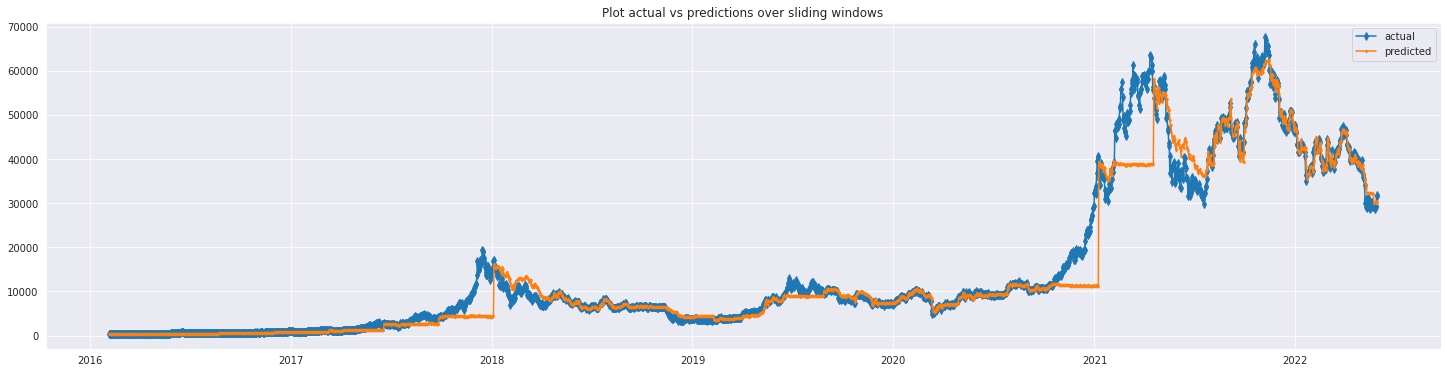

In [18]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

Note:

Tried to optimize the algorithm by hyperparameter tuning max_depth and max_features, but model is still overfitting.

## XGBoost Regressor

In [19]:
# https://www.geeksforgeeks.org/xgboost-for-regression/

model = XGBRegressor(n_estimators=500,objective='reg:squarederror', learning_rate =0.01)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  
  model.fit(x_train_windows,np.ravel(y_train_windows))

  y_train_pred_xgboost = model.predict(x_train_windows)
  y_test_pred_xgboost = model.predict(x_test_windows)

  y_pred.extend(np.ravel(y_test_pred_xgboost))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_xgboost)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_xgboost)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_xgboost)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_xgboost)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_xgboost)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_xgboost)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [20]:
xgboost_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [21]:
pd.DataFrame(xgboost_metrics.iloc[:,2:].mean())

,0
mae_train,243.349138
rmse_train,345.795861
mape_train,0.019333
mae_test,1729.709320
rmse_test,2195.640957
mape_test,0.146158


In [22]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

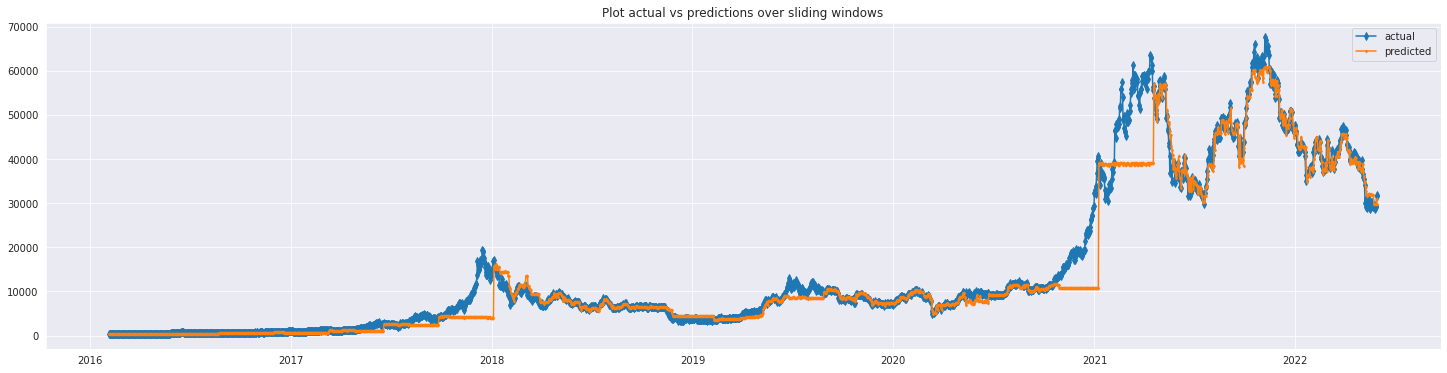

In [23]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

## AdaBoost Regressor

In [24]:
model = AdaBoostRegressor(random_state=42, n_estimators=100)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  
  model.fit(x_train_windows,np.ravel(y_train_windows))

  y_train_pred_adaboost = model.predict(x_train_windows)
  y_test_pred_adaboost = model.predict(x_test_windows)
  
  y_pred.extend(np.ravel(y_test_pred_adaboost))

  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_adaboost)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_adaboost)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_adaboost)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_adaboost)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_adaboost)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_adaboost)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])

In [25]:
adaboost_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [26]:
pd.DataFrame(adaboost_metrics.iloc[:,2:].mean())

,0
mae_train,384.701923
rmse_train,481.975200
mape_train,0.034088
mae_test,1762.949147
rmse_test,2229.591421
mape_test,0.148140


In [27]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

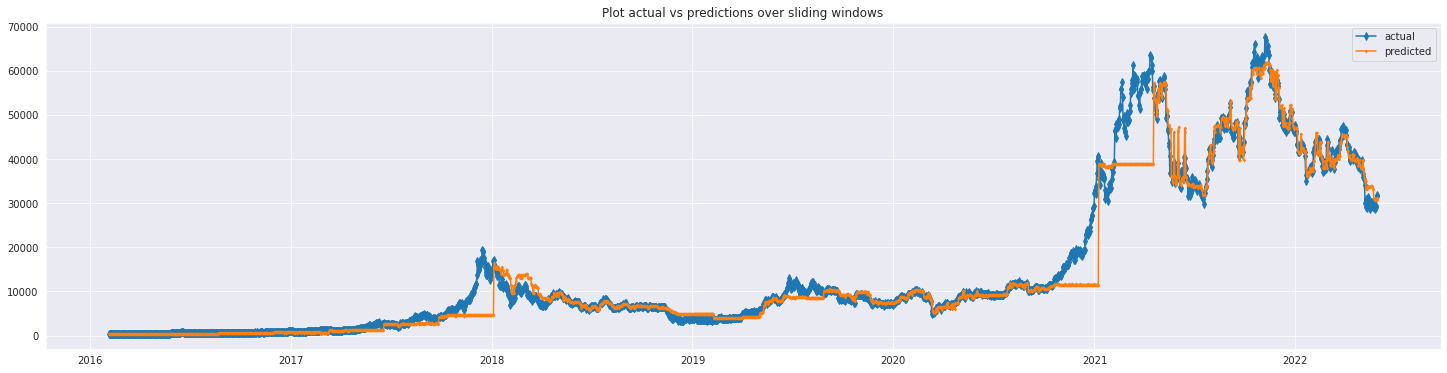

In [28]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()